**Proposta nova:**
- Uso de LLM para classificação e reescrita de politeness

**Tarefas:**
1. Fine Tune BERT (MultiClass) [<span style="color:deeppink;">**DONE**</span>] \
    1.1 Fazer pipeline de teste (estratégia: por enquanto maior score vence) [<span style="color:deeppink;">**IN PROGRESS**</span>]
2. Reescrever alguns impolites com o GPT e classificar pelo modelo fine-tuned
3. Talvez ver um modelo OHE dos P ou HP, e classificar se é polite a partir disso também

Extra:
- Dá para colocar os dados HP e P juntos, HI e I também, e treinar tudo de novo e avaliar tudo.

In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install --upgrade numpy
# %pip install seaborn
# %pip install scikit-learn
# %pip install ipywidgets
# %pip install tensorflow
# %pip install --upgrade gensim
# %pip install python-dotenv
# %pip install openai

## runtime compatibility problems (have to run even after install requirements.txt):
# %pip install tf-keras 
# %pip install evaluate
# %pip install accelerate

---

### Activate venv:

In [2]:
## Activate python venv:

# !python -m venv .venv
# Then, select the Jupyter kernel to use the venv, then execute the call below

In [3]:
## Install requirements in the .venv
# %pip install -r requirements.txt

In [4]:
## In case of updating requirements
# %pip freeze > requirements.txt

---

### > Imports

In [5]:
import pandas as pd
import os
from dotenv import load_dotenv
# import requests
from openai import OpenAI
from IPython.display import clear_output
from pprint import pprint
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer, TextClassificationPipeline
import numpy as np
import evaluate
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset 
import torch 
from datetime import date

load_dotenv()

OPENAI_PROJECT = os.getenv("OPENAI_PROJECT_ID")
OPENAI_APIKEY = os.getenv("OPENAI_APIKEY")

## Authenticate with OpenAI via CURL
# !curl https://api.openai.com/v1/models -H "Authorization: Bearer $OPENAI_APIKEY" -H "OpenAI-Project: $OPENAI_PROJECT"

# from keras.layers import TextVectorization
# from gensim import utils
# import gensim.models

%time


CPU times: total: 0 ns
Wall time: 0 ns


---
### Dataframe:

In [6]:
path = 'PolitenessDataset-FULL.csv'

# Original Dataframe
OriginalPolitenessDF = pd.read_csv(path)
# print('Data Stats:', OriginalPolitenessDF.describe())

# Experiments Dataframe
TargetDf = OriginalPolitenessDF.copy()

TargetDf.head(4)

,Venue,Review ID,review,Tone,Review URL
0,ShitMyReviewerSay,NaN,"It is early in the year, but difficult to imag...",2,NaN
1,ShitMyReviewerSay,NaN,You do not use the empirical data for the anal...,2,NaN
2,ShitMyReviewerSay,NaN,I understand that Wikipedia is not the best so...,3,NaN
3,ShitMyReviewerSay,NaN,Reviewer #1: 'The project can hardly be descri...,3,NaN


In [7]:
# Basic Transformations:

# Codificação
TargetDf['CodeVenue'] = TargetDf['Venue'].astype('category').cat.codes
# ReviewId
TargetDf['Index'] = TargetDf.index
# Reorder
TargetDf = TargetDf[['Index', 'CodeVenue', 'review', 'Tone']]
TargetDf.rename(columns={'review': 'RawReview'}, inplace=True)
TargetDf.head()

,Index,CodeVenue,RawReview,Tone
0,0,3,"It is early in the year, but difficult to imag...",2
1,1,3,You do not use the empirical data for the anal...,2
2,2,3,I understand that Wikipedia is not the best so...,3
3,3,3,Reviewer #1: 'The project can hardly be descri...,3
4,4,3,The figures are dishonest and not all that use...,2


---
### Pre Processamento:

In [8]:
def ReviewPreProcess(x: str):
    '''
    Esta função realiza:
    - Conversão para string
    - Remoção de Pontuação
    - Tudo minusculo
    - Remoção de links
    - Remoção de menções
    - Remoção de palavras com números
    - Normalização de espaços
    '''
    
    # Converter para string, caso não seja
    if not isinstance(x, str):
        return ''  # Retorna string vazia para entradas inválidas
    
    new_x = x
    for c in punctuation:
        new_x = new_x.replace(c,'')
    pattern = r"""
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """    
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

# TargetDf.rename(columns={'review': 'raw_review'}, inplace=True)
TargetDf['TransformedReview'] = TargetDf['RawReview'].apply(ReviewPreProcess)
TargetDf

,Index,CodeVenue,RawReview,Tone,TransformedReview
0,0,3,"It is early in the year, but difficult to imag...",2,it is early in the year but difficult to imagi...
1,1,3,You do not use the empirical data for the anal...,2,you do not use the empirical data for the anal...
2,2,3,I understand that Wikipedia is not the best so...,3,i understand that wikipedia is not the best so...
3,3,3,Reviewer #1: 'The project can hardly be descri...,3,reviewer the project can hardly be described...
4,4,3,The figures are dishonest and not all that use...,2,the figures are dishonest and not all that useful
...,...,...,...,...,...
2495,2495,3,The scientific contribution of this paper - if...,2,the scientific contribution of this paper if t...
2496,2496,3,Reviewer 2: The proposal is also poorly writte...,2,reviewer the proposal is also poorly written...
2497,2497,3,The paper could be considered for acceptance g...,3,the paper could be considered for acceptance g...
2498,2498,3,I don't see how your approach has potential to...,2,i dont see how your approach has potential to ...


Len of short reviews: 59


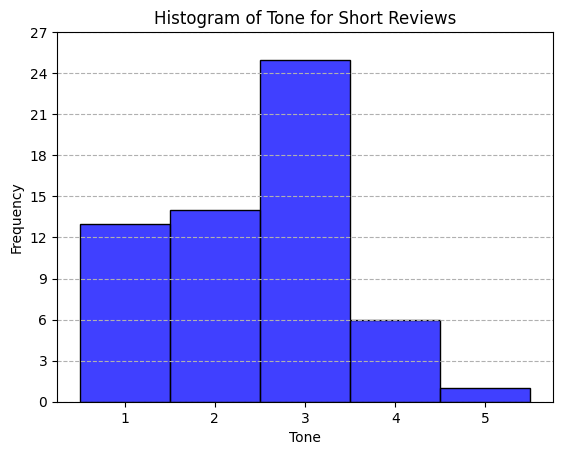

In [9]:
filtered_data = TargetDf[TargetDf['TransformedReview'].str.len() < 20]['Tone']

print('Len of short reviews:', len(filtered_data))

# use sns to create a histogram of the Tone column:
sns.histplot(filtered_data, kde=False, discrete=True, color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Histogram of Tone for Short Reviews')
plt.xlabel('Tone')
plt.ylabel('Frequency')
plt.yticks(range(0, 30, 3))
plt.grid(axis='y', linestyle='--')

# Mostrar o gráfico
plt.show()

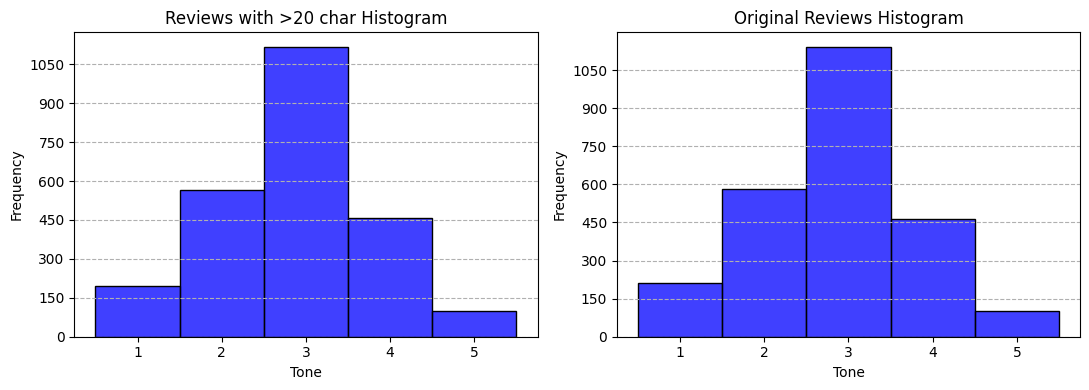

Filtered Dataframe: Tone
3    1117
2     567
4     459
1     197
5     101
Name: count, dtype: int64
Total of Reviews: 2441 

Original Dataframe: Tone
3    1142
2     581
4     465
1     210
5     102
Name: count, dtype: int64
Total of Original Reviews: 2500


In [10]:
# Only keep reviews with more than 20 characters
TargetDf2 = TargetDf[TargetDf['TransformedReview'].str.len() >= 20].copy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  # 1 row, 2 columns

# First subplot: Reviews with >20 characters
sns.histplot(TargetDf2['Tone'], kde=False, discrete=True, color='blue', ax=axes[0])
axes[0].set_title('Reviews with >20 char Histogram')
axes[0].set_xlabel('Tone')
axes[0].set_ylabel('Frequency')
axes[0].set_yticks(range(0, 1200, 150))
axes[0].grid(axis='y', linestyle='--')

# Second subplot: Original Reviews
sns.histplot(TargetDf['Tone'], kde=False, discrete=True, color='blue', ax=axes[1])
axes[1].set_title('Original Reviews Histogram')
axes[1].set_xlabel('Tone')
axes[1].set_ylabel('Frequency')
axes[1].set_yticks(range(0, 1200, 150))
axes[1].grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

# quantity of tones for both dataframes:
print('Filtered Dataframe:', TargetDf2['Tone'].value_counts())
print('Total of Reviews:', len(TargetDf2), '\n')
print('Original Dataframe:', TargetDf['Tone'].value_counts())
print('Total of Original Reviews:', len(TargetDf))

--- 
### Separate Train x Test data: 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(TargetDf2['TransformedReview'], TargetDf2['Tone'], test_size=0.2, random_state=42)

y_train = y_train - 1
y_test = y_test - 1


---
### Fine-Tune BERT:

#### Load Model (Already Fine-Tuned):

In [13]:
# Load from local
local_path = 'bert-treined261224'
model_trained = AutoModelForSequenceClassification.from_pretrained(local_path)
tokenizer = AutoTokenizer.from_pretrained(local_path)

#### Fine-Tune Model Pipeline:

**IMPORTANT:**\
Here, <font color='yellow'>**only fine-tune**</font> the model (run cells below) if: 
- Desired: For new experiments
- Don't have a fine-tuned model saved

In [ ]:
# model_base = 'bert-base-uncased' ## Uncomment this in case of fine-tuning the model (commented here to avoid running everything)
tokenizer = AutoTokenizer.from_pretrained(model_base) 

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=128,  # Adjust this as needed
            return_tensors="pt",
        )
        # Return a dictionary with the required fields
        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),  # Label tensor
        }

# Prepare the datasets
train_dataset = CustomDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
output_dir = './bert'
training_args = TrainingArguments(
    output_dir=output_dir,                    # Nome e diretório do modelo final
    num_train_epochs=3,                       # Número de épocas
    per_device_train_batch_size=8,            # Tamanho do lote (batch) por GPU
    per_device_eval_batch_size=8,             # Tamanho do lote (batch) para validação por GPU
    weight_decay=0.01,                        # Força de decaimento
    logging_dir='./logs',                     # Pasta para salvar logs
    logging_steps=100,                        # Logar a cada N etapas
    eval_strategy='steps',                    # Estratégia de avaliação
    eval_steps=200,                           # Rodar avaliação a cada N etapas
    save_total_limit=2,                       # Salvar apenas os ultimos N checkpoints
    save_steps=200,                           # Salvar checkpoint a cada N etapas.
    load_best_model_at_end=True,              # Carregar o melhor modelo no fim
    metric_for_best_model='accuracy',         # Métrica para encontrar o melhor modelo
)

model = AutoModelForSequenceClassification.from_pretrained(model_base, num_labels=5)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train() ## ~28-31 min

simple_date = date.today().strftime('%d%m%y')
trainer.save_model('bert-treined'+simple_date)

%time

#### Test the model:

In [14]:
# Sample prediction:

pipe = TextClassificationPipeline(model=model_trained, tokenizer=tokenizer)
prediction = pipe("This article looks like shit", top_k=None)
prediction

[{'label': 'LABEL_0', 'score': 0.6987417936325073},
 {'label': 'LABEL_1', 'score': 0.25321346521377563},
 {'label': 'LABEL_4', 'score': 0.018354864791035652},
 {'label': 'LABEL_3', 'score': 0.01649334840476513},
 {'label': 'LABEL_2', 'score': 0.013196535408496857}]

In [15]:
def ClassificationResult(classf_results: list, review_text: str, index, prediction):
    final_result = {'label':'', 'score':0} # starts with zero
    # Classification based on higher score:
    for result in prediction:
        if round(result['score'],5) > final_result['score']:
            final_result = {
                'label': result['label'],
                'score': round(result['score'],5)}
    # Append classf_results   
    match final_result['label']:
        case 'LABEL_0': # HI
            classf_results.append({
                'review':review_text,
                'label':'1',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_1': # I
            classf_results.append({
                'review':review_text,
                'label':'2',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_2': # Neutral
            classf_results.append({
                'review':review_text,
                'label':'3',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_3': # P
            classf_results.append({
                'review':review_text,
                'label':'4',
                'score':final_result['score'],
                'index':index,}) 
        case 'LABEL_4': # HP
            classf_results.append({
                'review':review_text,
                'label':'5',
                'score':final_result['score'],
                'index':index,})

classf_results = [] 
test_dataframe = pd.DataFrame({'review': X_test, 'tone': y_test})

for index, row in test_dataframe.iterrows():
    prediction = pipe(row['review'], top_k=None)
    ClassificationResult(classf_results, row['review'], index, prediction)

classf_results

%time 

[{'review': 'all the comments have been successfully addressed',
  'label': '4',
  'score': 0.77732,
  'index': 2368},
 {'review': 'the writing is often arrestingly pedestrian',
  'label': '4',
  'score': 0.3593,
  'index': 642},
 {'review': 'the paper seems wellwritten and technically sound i suggest to improve the presentation and the clarity of section',
  'label': '4',
  'score': 0.77032,
  'index': 2259},
 {'review': 'surely if we reduce overfitting then by definition there would have to be an improvement in generalization performance so should we draw the conclusion that the method has not actually been demonstrated to reduce overfitting',
  'label': '3',
  'score': 0.93592,
  'index': 1643},
 {'review': 'the authors have satisfactorily adressed to reviewers concerns',
  'label': '4',
  'score': 0.78587,
  'index': 2409},
 {'review': 'it is not hard to develop this methodi could write code for this on a rainy afternoon',
  'label': '2',
  'score': 0.83799,
  'index': 506},
 {'rev

In [113]:
# Preparing for confusion matrix

predicted_dataframe = pd.DataFrame(classf_results)
predicted_dataframe.set_index('index', inplace=True)
df3 = pd.concat([test_dataframe, predicted_dataframe[['label','score']]], axis=1)
df3.rename(columns={'label':'predicted_label'}, inplace=True)
df3['tone'] = df3['tone'] + 1
df3

,review,tone,predicted_label,score
2368,all the comments have been successfully addressed,3,4,0.77732
642,the writing is often arrestingly pedestrian,2,4,0.35930
2259,the paper seems wellwritten and technically so...,3,4,0.77032
1643,surely if we reduce overfitting then by defini...,4,3,0.93592
2409,the authors have satisfactorily adressed to re...,4,4,0.78587
...,...,...,...,...
1063,i do not understand why we would like to assume,2,2,0.83550
1686,it seems you have exchanged first name and las...,2,2,0.79779
237,it is unclear how this would advance the field...,2,3,0.95192
441,pity about the main thesis,3,2,0.66619


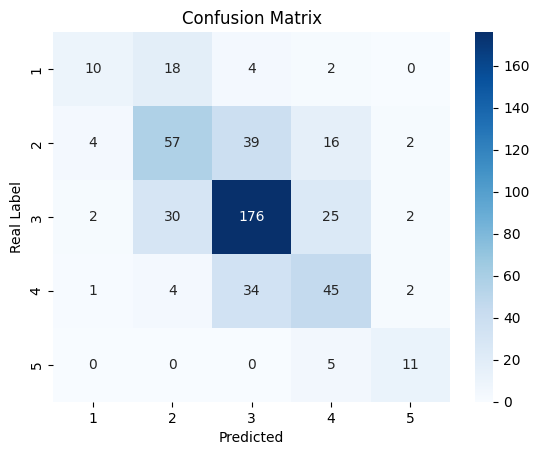

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the range of labels explicitly (1 to 5)
label_range = [1, 2, 3, 4, 5]

# Generate the confusion matrix
conf_matrix = confusion_matrix(
    df3['tone'].astype(int), 
    df3['predicted_label'].astype(int), 
    labels=label_range
)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_range, yticklabels=label_range)
plt.xlabel('Predicted')
plt.ylabel('Real Label')
plt.title('Confusion Matrix')
plt.show()

Reescrever alguns Real Impolite como polite e testar:

In [ ]:
## TODO: here

In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

mapDict = {
    "HI": 1,
    "I": 2,
    "N": 3,
    "P": 4,
    "HP": 5
}

def transform_labels(label):
    label = label["label"]

    result = []
    for l in label:
      result.append(mapDict[l])


    return {"label": result} 

def tokenize_function(example):
    # return tokenizer(example["TransformedReview"], padding=True, truncation=True)
    return tokenizer(example["TransformedReview"])


tokenized_datasets = TargetDf2.map(tokenize_function)
# tokenized_datasets = tokenized_datasets.map(transform_labels, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

---
### OpenAi Call:

In [28]:
# Test Sample
X = TargetDf.sample(1)
X_text = X['review'].values[0]
X_tone = X['Tone'].values[0]
pprint(['Sample Text:', X_text,]) 
print('Tone:', X_tone,'\n')

# ChatGPT:
client = OpenAI(
    api_key=OPENAI_APIKEY,
    project=OPENAI_PROJECT
)

Sample1 = X_text
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
        {"role": "user", "content":     "I need help with a Peer Review comment.\
                                        in a scale of 1 - 5 classify the comment about it's Politeness.\
                                        How to classify (in a range):\
                                        Highly Impolite (1): Comments containing unnecessarily offensive, sarcastic,\
                                        or disrespectful critiques, using derogatory terms or expressing disdain for the reviewed work.\
                                        Highly Polite (5): Comments explicitly emphasizing positive aspects, using linguistic mitigations,\
                                        direct praise, and respectful language to convey critiques or suggestions.\
                                        Neutral (3) would be a comment that is neither polite nor impolite.\
                                        Bring the rank first, then after a 2 line explanation why, of this comment:"+Sample1},
    ]
)

pprint(completion.choices[0].message.content)

['Sample Text:', 'Are the \'10 random reps" chosen at random?']
Tone: 3 

('4: The comment is phrased as a polite question and serves to seek '
 "clarification without any negative tone. It doesn't contain any offensive "
 'language and would generally be considered as an inquiry for understanding '
 'rather than a critique.')


In [ ]:
#write a file with the response:

with open("resposta1.md", "w") as f:
    f.write(completion.choices[0].message.content)

In [ ]:
# # train test split
# X_train, X_test, y_train, y_test = train_test_split(test[['review','Tone']], test['Tone'], test_size=0.2, random_state=42)

# max_length = X_train['review'].str.len().max()
# print(f"The maximum length of characters is: {max_length}")

# # Lengths of each review
# lengths = X_train['review'].dropna().astype(str).str.len()

In [5]:
# Some visuals

# Plotting the distribution of the sources
PolitenessDF['Venue'].value_counts().plot(title='Sources Freq', kind='bar')
plt.show()

# Tone distribution
plt.figure(figsize=(10, 6))
sns.histplot(PolitenessDF['Tone'], bins=5, fill=True, color='blue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.title("Histogram of Politeness Tones", fontsize=16)
plt.xlabel("Tone", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Plot tone per venue, stacked
PolitenessDF.groupby(['Venue', 'Tone']).size().unstack().plot(kind='bar', stacked=True, title='Tone per Venue')
plt.show()

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True, color='blue', alpha=0.7)  # Seaborn for enhanced visuals
plt.title("Histogram of Review Lengths", fontsize=16)
plt.xlabel("Review Length (characters)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

clear_output() 